In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import joblib
from datetime import timedelta

from datasets import GermanWeatherEnergyData

In [2]:
def plot_feature(data, time_column, feature_column):
    """
    Plot a feature from a time series dataset.

    Parameters:
    data (pd.DataFrame): The dataset containing the time series data.
    time_column (str): The name of the time column.
    feature_column (str): The name of the feature column to be plotted.
    """
    # Ensure that the time column is in datetime format
    data[time_column] = pd.to_datetime(data[time_column])

    # Plot the feature
    plt.figure(figsize=(12, 6))
    plt.plot(data[time_column], data[feature_column], label=feature_column)
    plt.xlabel('Time')
    plt.ylabel(feature_column)
    plt.title(f'{feature_column}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
def plot_feature_distribution(df, feature_name, bins=10, log_feature=False):
    """
    Plot the distribution of a feature in the dataset.
    
    Parameters:
    df (pd.DataFrame): The dataset.
    feature_name (str): The feature/column name to plot.
    """
    if feature_name not in df.columns:
        print(f"Feature '{feature_name}' not found in the dataset.")
        return
    if log_feature:
        feature = np.log1p(df[feature_name])
    else:
        feature = df[feature_name]
    
    plt.figure(figsize=(10, 6))
    sns.histplot(feature, kde=True, bins=bins)
    plt.title(f"Distribution of '{feature_name}'")
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [4]:
def plot_and_sort_correlations(df):
    # Calculate the correlation matrix
    corr_matrix = df.corr()
    
    # Plot the correlation matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()
    
    # Calculate and sort correlations
    corr_pairs = corr_matrix.unstack().reset_index()
    corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
    
    # Remove self-correlations (correlation of a feature with itself)
    corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]
    
    # Drop duplicate pairs (like (A, B) and (B, A))
    corr_pairs['abs_correlation'] = corr_pairs['Correlation'].abs()
    corr_pairs = corr_pairs.sort_values(by='abs_correlation', ascending=False).drop_duplicates(subset=['abs_correlation'])
    
    # Drop the auxiliary column
    corr_pairs = corr_pairs.drop(columns=['abs_correlation'])
    
    # Print the sorted correlations
    print("Sorted correlations:")
    print(corr_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True))
    
    return corr_pairs


In [5]:
def preprocess_data(train, test, val, scaler, columns, gwe):   
    """
    Apply the specified scaler to the specified columns of the data.
    Args:   
    train (tuple): The training data (X, y).
    test (tuple): The test data (X, y).
    val (tuple): The validation data (X, y).
    scaler (sklearn.preprocessing object): The scaler to apply.
    columns (list): The columns to which the scaler should be applied.
    gwe (GermanWeatherEnergyData): The GermanWeatherEnergyData object containing the data.
    Returns:
    tuple: The preprocessed training data (X, y).
    tuple: The preprocessed test data (X, y).
    tuple: The preprocessed validation data (X, y).
    scaler: The fitted scaler. This can be used to do inverse transformations.
    """ 
    X_train, y_train = train
    X_test, y_test = test
    X_val, y_val = val
    # Copy the data to avoid modifying the original DataFrames
    X_train_transformed = X_train.copy()
    X_test_transformed = X_test.copy()
    X_val_transformed = X_val.copy()
    
    # Apply the scaler only to the specified columns
    X_train_transformed[columns] = scaler.fit_transform(X_train_transformed[columns])
    X_test_transformed[columns] = scaler.transform(X_test_transformed[columns])
    X_val_transformed[columns] = scaler.transform(X_val_transformed[columns])

    # Prepare data
    (short_train, long_train) = gwe.prepare_data(X_train_transformed.drop(columns=['time']), y_train)
    (short_test, long_test) = gwe.prepare_data(X_test_transformed.drop(columns=['time']), y_test)
    (short_val, long_val) = gwe.prepare_data(X_val_transformed.drop(columns=['time']), y_val)
    return (short_train, long_train), (short_test, long_test), (short_val, long_val), scaler

In [6]:
def train_test_model(model, X_train, y_train, X_test, y_test, checkpoint_name, horizon):
    time_start = time.time()
    model.fit(X_train, y_train)
    training_duration = timedelta(seconds=(time.time() - time_start))
    print(f"Training time ({horizon} hour in advance): {training_duration}")
    joblib.dump(model, checkpoint_name)

    y_pred_train = model.predict(X_train)
  
    train_rmse = sqrt(mean_squared_error(y_train, y_pred_train))
    print(f"Train RMSE ({horizon} hour in advance):", train_rmse)

    time_start = time.time()
    y_pred_test = model.predict(X_test)
    prediction_duration = timedelta(seconds=(time.time() - time_start))
    print(f"Prediction time test set({horizon} hour in advance): {prediction_duration}")

    test_rmse = sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"Test RMSE ({horizon} hour in advance):", test_rmse)
    
    return model, y_pred_test, test_rmse, y_pred_train, train_rmse

## Photovoltaics

In [7]:
data_dir = "../data/"
# target indices: 63 photovoltaic supply, 62 wind onshore supply, 61 wind offshore supply
window_size = 24 * 3 # 3 days
gwe = GermanWeatherEnergyData(data_dir=data_dir, window_size= window_size, target_idx=63, short_horizon=1, long_horizon=24) 

Loading and preprocessing data...
Loaded weather data in 6.80 seconds.
Loaded energy data in 0.81 seconds.
Merged realisation data in 0.02 seconds.
Converted to datetime format in 0.62 seconds.
Converted energy data to UTC in 0.03 seconds.
Filled missing weather data in 0.17 seconds.
Clustered and aggregated locations in 37.83 seconds.
Filled missing energy data in 37.84 seconds.
Combined weather and energy data in 0.02 seconds.
Split time into integers in 0.02 seconds.
Processed data generated successfully.


In [8]:
train,val, test = gwe.get_train_val_test_data()

From function get_train_val_test_data:
photovoltaic_supply


In [9]:
train[0].columns

Index(['time', 'bottom_left_cdir', 'bottom_right_cdir', 'top_left_cdir',
       'top_right_cdir', 'bottom_left_z', 'bottom_right_z', 'top_left_z',
       'top_right_z', 'bottom_left_msl', 'bottom_right_msl', 'top_left_msl',
       'top_right_msl', 'bottom_left_blh', 'bottom_right_blh', 'top_left_blh',
       'top_right_blh', 'bottom_left_tcc', 'bottom_right_tcc', 'top_left_tcc',
       'top_right_tcc', 'bottom_left_u10', 'bottom_right_u10', 'top_left_u10',
       'top_right_u10', 'bottom_left_v10', 'bottom_right_v10', 'top_left_v10',
       'top_right_v10', 'bottom_left_t2m', 'bottom_right_t2m', 'top_left_t2m',
       'top_right_t2m', 'bottom_left_ssr', 'bottom_right_ssr', 'top_left_ssr',
       'top_right_ssr', 'bottom_left_tsr', 'bottom_right_tsr', 'top_left_tsr',
       'top_right_tsr', 'bottom_left_sund', 'bottom_right_sund',
       'top_left_sund', 'top_right_sund', 'bottom_left_tp', 'bottom_right_tp',
       'top_left_tp', 'top_right_tp', 'bottom_left_fsr', 'bottom_right_fsr',
  

In [10]:
def has_missing_vals(arr):
    has_missing_values = np.isnan(arr).any()
    print("Does the array have any missing values?", has_missing_values)

In [11]:
columns = train[0].columns.tolist()
exclude_columns = ['time', 'month_cos', 'month_sin', 'day_cos', 'day_sin', 'hour_cos', 'hour_sin']
columns_to_transform = [col for col in columns if col not in exclude_columns]
(short_train, long_train), (short_test, long_test), (short_val, long_val), scaler = preprocess_data(train, test, val, MinMaxScaler(), columns_to_transform, gwe)

In [12]:
# training
# short horizon
has_missing_vals(short_train[0])
has_missing_vals(short_train[1])
# long horizon
has_missing_vals(long_train[0])
has_missing_vals(long_train[1])

# validation
# short horizon
has_missing_vals(short_val[0])
has_missing_vals(short_val[1])
# long horizon
has_missing_vals(long_val[0])
has_missing_vals(long_val[1])

# test
# short horizon
has_missing_vals(short_test[0])
has_missing_vals(short_test[1])
# long horizon
has_missing_vals(long_test[0])
has_missing_vals(long_test[1])

Does the array have any missing values? False
Does the array have any missing values? False
Does the array have any missing values? False
Does the array have any missing values? False
Does the array have any missing values? False
Does the array have any missing values? False
Does the array have any missing values? False
Does the array have any missing values? False
Does the array have any missing values? False
Does the array have any missing values? False
Does the array have any missing values? False
Does the array have any missing values? False


In [13]:
combined_short_X = np.concatenate((short_train[0], short_val[0]), axis=0)
combined_short_y = np.concatenate((short_train[1], short_val[1]), axis=0)

combined_long_X = np.concatenate((long_train[0], long_val[0]), axis=0)
combined_long_y = np.concatenate((long_train[1], long_val[1]), axis=0)

In [15]:
print("1 hour ahead training data dimension", short_train[0].shape)
print("24 hours ahead training data dimension", long_train[0].shape)
print("1 hour ahead test data dimension", short_test[0].shape)
print("24 hours ahead test data dimension", long_test[0].shape)

1 hour ahead training data dimension (17449, 5544)
24 hours ahead training data dimension (17449, 5544)
1 hour ahead test data dimension (8641, 5544)
24 hours ahead test data dimension (8641, 5544)


### short horizon

In [17]:
svr_short_photo, y_pred_short_test_photo,test_short_rmse_photo, y_pred_short_train_photo, train_short_rmse_photo = train_test_model(SVR(C = 100, kernel='rbf', gamma= 'scale', epsilon=0.01), combined_short_X, combined_short_y, short_test[0], short_test[1],'svr_photovolaics_short_model.pkl', 1)
np.save('y_pred_short_test_photo.npy', y_pred_short_test_photo)
np.save('y_pred_short_train_photo.npy', y_pred_short_train_photo)
# 00:47:48 to train
# 00:15:39 to test


Training time (1 hour in advance): 2867.129374027252
Train RMSE (1 hour in advance): 292.502348535034
Prediction time test set(1 hour in advance): 674.2857692241669
Test RMSE (1 hour in advance): 938.9026695204906


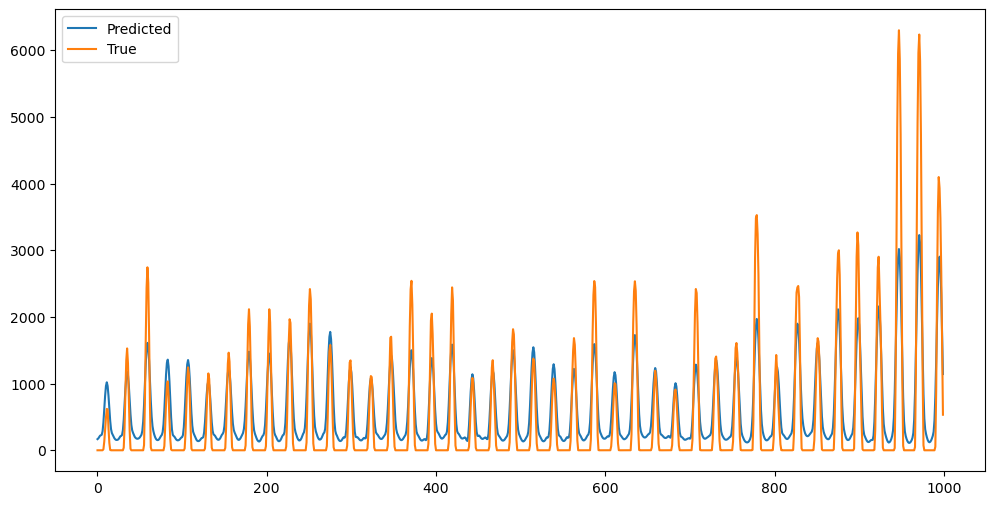

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(y_pred_short_test_photo[:1000], label='Predicted')
plt.plot(short_test[1][:1000], label='True')
plt.legend()
plt.show()


### long horizon

In [29]:
svr_long_photo, y_pred_long_test_photo, test_long_rmse_photo, y_pred_long_train_photo, train_long_rmse_photo = train_test_model(SVR(C = 0.1, kernel='rbf', gamma= 0.001, epsilon=0.2), combined_long_X, combined_long_y, long_test[0], long_test[1],'svr_photovolaics_long_model.pkl', 24)
np.save('y_pred_long_test_photo.npy', y_pred_long_test_photo)
np.save('y_pred_long_train_photo.npy', y_pred_long_train_photo)
# 00:29:02 train
# 00:29:28 test


Training time (1 hour in advance): 1741.442260503769
Train RMSE (1 hour in advance): 2202.4794050511764
Prediction time test set(1 hour in advance): 1768.3545382022858
Test RMSE (1 hour in advance): 2763.3832861289366


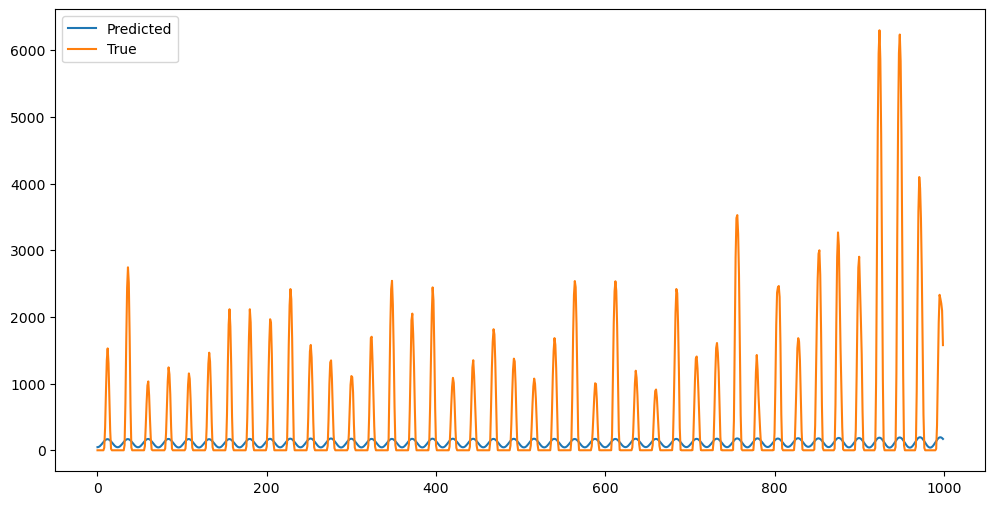

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(y_pred_long_test_photo[:1000], label='Predicted')
plt.plot(long_test[1][:1000], label='True')
plt.legend()
plt.show()

## Wind onshore

In [8]:
data_dir = "../data/"
# target indices: 63 photovoltaic supply, 62 wind onshore supply, 61 wind offshore supply
window_size = 24 * 3 # 3 days
gwe = GermanWeatherEnergyData(data_dir=data_dir, window_size= window_size, target_idx=62, short_horizon=1, long_horizon=24) 

Loading and preprocessing data...
Loaded weather data in 7.13 seconds.
Loaded energy data in 0.92 seconds.
Merged realisation data in 0.02 seconds.
Converted to datetime format in 0.62 seconds.
Converted energy data to UTC in 0.04 seconds.
Filled missing weather data in 0.17 seconds.
Clustered and aggregated locations in 40.14 seconds.
Filled missing energy data in 40.15 seconds.
Combined weather and energy data in 0.02 seconds.
Split time into integers in 0.02 seconds.
Processed data generated successfully.


In [9]:
train_onshore,val_onshore, test_onshore = gwe.get_train_val_test_data()

From function get_train_val_test_data:
wind_onshore_supply


In [10]:
columns = train_onshore[0].columns.tolist()
exclude_columns = ['time', 'month_cos', 'month_sin', 'day_cos', 'day_sin', 'hour_cos', 'hour_sin']
columns_to_transform = [col for col in columns if col not in exclude_columns]
(short_train_onshore, long_train_onshore), (short_test_onshore, long_test_onshore), (short_val_onshore, long_val_onshore), scaler_onshore_long = preprocess_data(train_onshore, test_onshore, val_onshore, MinMaxScaler(), columns_to_transform, gwe)

In [11]:
combined_short_X_onshore = np.concatenate((short_train_onshore[0], short_val_onshore[0]), axis=0)
combined_short_y_onshore = np.concatenate((short_train_onshore[1], short_val_onshore[1]), axis=0)

combined_long_X_onshore= np.concatenate((long_train_onshore[0], long_val_onshore[0]), axis=0)
combined_long_y_onshore = np.concatenate((long_train_onshore[1], long_val_onshore[1]), axis=0)

### short horizon

In [15]:
svr_short_onshore, y_pred_short_test_onshore,test_short_rmse_onshore, y_pred_short_train_onshore, train_short_rmse_onshore = train_test_model(SVR(C = 100, kernel='rbf', gamma= 'scale', epsilon=0.01), combined_short_X_onshore, combined_short_y_onshore, short_test_onshore[0], short_test_onshore[1],'svr_onshore_short_model.pkl', 1)
np.save(f"y_pred_short_test_onshore.npy", y_pred_short_test_onshore)
np.save(f"y_pred_short_train_onshore.npy", y_pred_short_train_onshore)
# 00:28:49 train time
# 00:11:07 test time

Training time (1 hour in advance): 1728.6101586818695
Train RMSE (1 hour in advance): 785.1519767806885
Prediction time test set(1 hour in advance): 666.9101526737213
Test RMSE (1 hour in advance): 1363.6084405809784


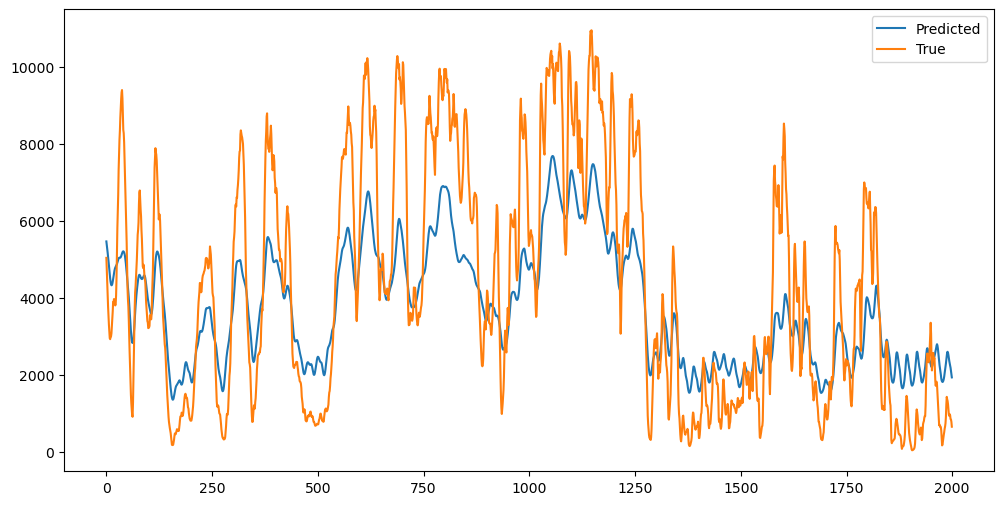

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(y_pred_short_test_onshore[:2000], label='Predicted')
plt.plot(short_test_onshore[1][:2000], label='True')
plt.legend()
plt.show()

### long horizon

In [18]:
svr_long_onshore, y_pred_long_test_onshore,test_long_rmse_onshore, y_pred_long_train_onshore, train_long_rmse_onshore = train_test_model(SVR(C = 100, kernel='rbf', gamma= 'scale', epsilon=0.01), combined_long_X_onshore, combined_long_y_onshore, long_test_onshore[0], long_test_onshore[1],'svr_onshore_long_model.pkl', 24)
np.save(f"y_pred_long_test_onshore.npy", y_pred_long_test_onshore)
np.save(f"y_pred_long_train_onshore.npy", y_pred_long_train_onshore)
# 00:23:10 train
# 00:10:34 test


Training time (24 hour in advance): 1390.9916055202484
Train RMSE (24 hour in advance): 1280.1741270512264
Prediction time test set(24 hour in advance): 633.7197284698486
Test RMSE (24 hour in advance): 1861.9554864951197


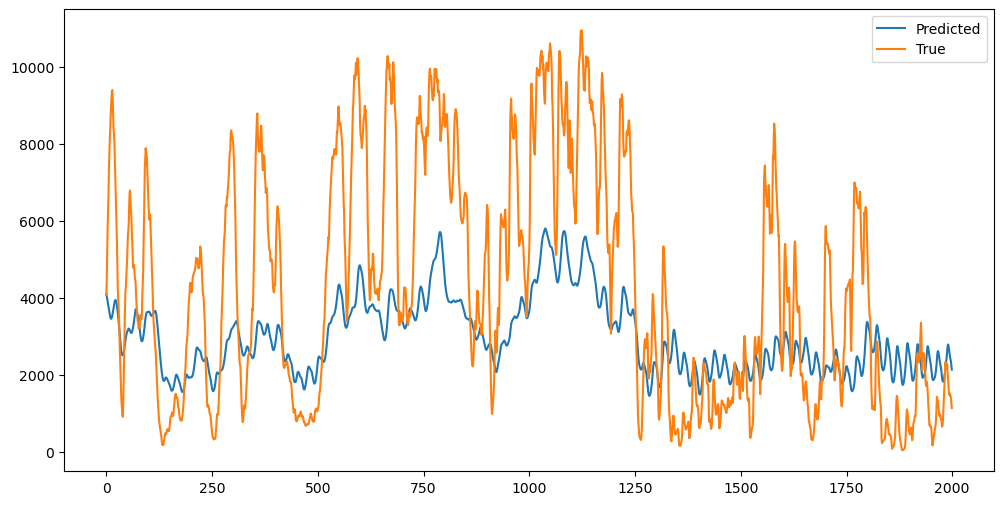

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(y_pred_long_test_onshore[:2000], label='Predicted')
plt.plot(long_test_onshore[1][:2000], label='True')
plt.legend()
plt.show()

## Wind offshore

In [12]:
data_dir = "../data/"
# target indices: 63 photovoltaic supply, 62 wind onshore supply, 61 wind offshore supply
window_size = 24 * 3 # 3 days
gwe = GermanWeatherEnergyData(data_dir=data_dir, window_size= window_size, target_idx=61, short_horizon=1, long_horizon=24) 
train_offshore,val_offshore, test_offshore = gwe.get_train_val_test_data()
columns = train_offshore[0].columns.tolist()
exclude_columns = ['time', 'month_cos', 'month_sin', 'day_cos', 'day_sin', 'hour_cos', 'hour_sin']
columns_to_transform = [col for col in columns if col not in exclude_columns]
(short_train_offshore, long_train_offshore), (short_test_offshore, long_test_offshore), (short_val_offshore, long_val_offshore), scaler_offshore = preprocess_data(train_offshore, test_offshore, val_offshore, MinMaxScaler(), columns_to_transform, gwe)

combined_short_X_offshore = np.concatenate((short_train_offshore[0], short_val_offshore[0]), axis=0)
combined_short_y_offshore = np.concatenate((short_train_offshore[1], short_val_offshore[1]), axis=0)

combined_long_X_offshore= np.concatenate((long_train_offshore[0], long_val_offshore[0]), axis=0)
combined_long_y_offshore = np.concatenate((long_train_offshore[1], long_val_offshore[1]), axis=0)

Loading and preprocessing data...
Loaded weather data in 3.80 seconds.
Loaded energy data in 0.47 seconds.
Merged realisation data in 0.01 seconds.
Converted to datetime format in 0.35 seconds.
Converted energy data to UTC in 0.02 seconds.
Filled missing weather data in 0.14 seconds.
Clustered and aggregated locations in 18.61 seconds.
Filled missing energy data in 18.61 seconds.
Combined weather and energy data in 0.01 seconds.
Split time into integers in 0.01 seconds.
Processed data generated successfully.
From function get_train_val_test_data:
wind_offshore_supply


### short horizon

In [22]:
svr_short_offshore, y_pred_short_test_offshore,test_short_rmse_offshore, y_pred_short_train_offshore, train_short_rmse_offshore = train_test_model(SVR(C = 100, kernel='rbf', gamma= 'scale', epsilon=0.01), combined_short_X_offshore, combined_short_y_offshore, short_test_offshore[0], short_test_offshore[1],'svr_offshore_short_model.pkl', 1)
np.save(f"y_pred_short_test_offshore.npy", y_pred_short_test_offshore)
np.save(f"y_pred_short_train_offshore.npy", y_pred_short_train_offshore)
# 00:51:46 train
# 00:11:19 test

Training time (1 hour in advance): 3106.9576511383057
Train RMSE (1 hour in advance): 155.53015111745177
Prediction time test set(1 hour in advance): 678.886825799942
Test RMSE (1 hour in advance): 257.07541636012985


In [14]:
plt.figure(figsize=(12, 6))
plt.plot(y_pred_short_test_offshore[:2000], label='Predicted')
plt.plot(long_test_offshore[1][:2000], label='True')
plt.legend()
plt.show()

NameError: name 'y_pred_short_test_offshore' is not defined

<Figure size 1200x600 with 0 Axes>

### long horizon

In [13]:
svr_long_offshore, y_pred_long_test_offshore,test_long_rmse_offshore, y_pred_long_train_offshore, train_long_rmse_offshore = train_test_model(SVR(C = 100, kernel='rbf', gamma= 'scale', epsilon=0.01), combined_long_X_offshore, combined_long_y_offshore, long_test_offshore[0], long_test_offshore[1],'svr_offshore_long_model.pkl', 24)
np.save(f"y_pred_long_test_offshore.npy", y_pred_long_test_offshore)
np.save(f"y_pred_long_train_offshore.npy", y_pred_long_train_offshore)
# 00:22:47 train
# 00:10:58 test

Training time (24 hour in advance): 1367.0031917095184
Train RMSE (24 hour in advance): 313.63059022820687
Prediction time test set(24 hour in advance): 658.7695412635803
Test RMSE (24 hour in advance): 392.3574705678193


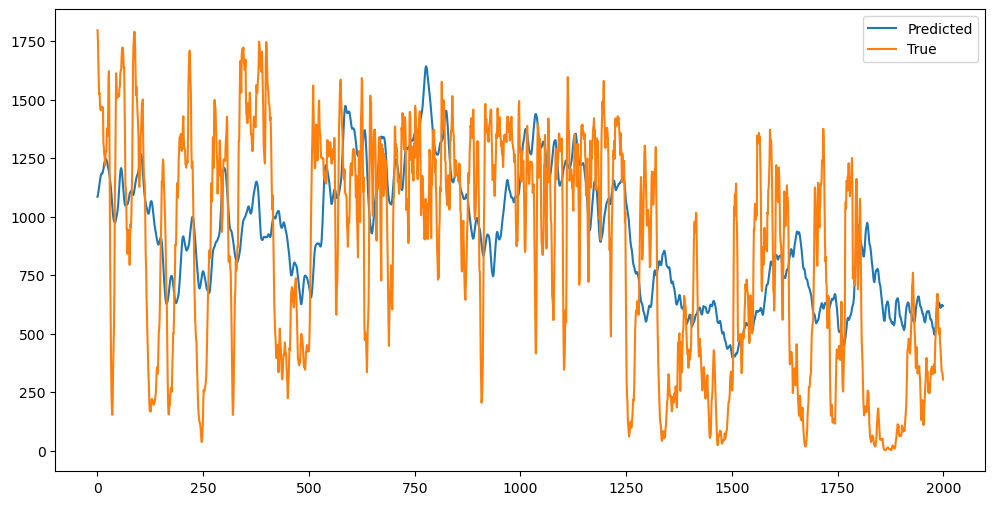

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_pred_long_test_offshore[:2000], label='Predicted')
plt.plot(long_test_offshore[1][:2000], label='True')
plt.legend()
plt.show()

In [21]:
start_date_test = test_offshore[0].iloc[:, 0][0]
end_date_test = test_offshore[0].iloc[:, 0][len(test_offshore[0]) - 1]
print("Start date test set:", start_date_test)
print("End date test set:", end_date_test)

Start date test set: 2022-01-01 00:00:00
End date test set: 2022-12-30 23:00:00
